<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Exploratory Data Analysis on a Natural Language Processing Task

---

Exploratory data analysis (EDA) is a crucial part of any data science project. EDA helps us discover interesting relationships in the data, detect outliers and errors, examine our own assumptions about the data, and prepare for modeling. During EDA we might discover that we need to clean our data more conscientiously, or that we have more missing data than we realized, or that there aren't many patterns in the data (indicating that modeling may be challenging.)

In this lab you'll bring in a natural language dataset and perform EDA. The dataset contains Facebook statuses taken from between 2009 and 2011 as well as personality test results associated with the users whose Facebook statuses are included.

This dataset uses results from the Big Five Personality Test, also referred to as the five-factor model, which measures a person's score on five dimensions of personality:
- **O**penness
- **C**onscientiousness
- **E**xtroversion
- **A**greeableness
- **N**euroticism

Notoriously, the political consulting group Cambridge Analytica claims to have predicted the personalities of Facebook users by using those users' data, with the goal of targeting them with political ads that would be particularly persuasive given their personality type. Cambridge Analytica claims to have considered 32 unique 'groups' in the following fashion:
- For each of the five OCEAN qualities, a user is categorized as either 'yes' or 'no'.
- This makes for 32 different potential combinations of qualities. ($2^5 = 32$).

Cambridge Analytica's methodology was then, roughly, the following:
- Gather a large amount of data from Facebook.
- Use this data to predict an individual's Big Five personality "grouping."
- Design political advertisements that would be particularly effective to that particular "grouping." (For example, are certain advertisements particularly effective toward people with specific personality traits?)

In this lab you will perform EDA to examine many relationships in the data.

Exploratory data analysis can be a non-linear process, and you're encouraged to explore questions that occur to you as you work through the notebook.

> **Content note**: This dataset contains real Facebook statuses scraped from 2009 to 2011, and some of the statuses contain language that is not safe for work, crude, or offensive. The full dataset is available as `mypersonality.csv`, and a sanitized version containing only statuses that passed an automated profanity check is available as `mypersonality_noprofanity.csv`. Please do not hesitate to use `mypersonality_noprofanity.csv` if you would prefer to. Please note that the automated profanity check is not foolproof. If you have any concerns about working with this dataset, please get in touch with your instructional team.

---

### External resources

These resources are not required reading but may be of use or interest.

- [**Python Graph Gallery**](https://python-graph-gallery.com/)
- [**Wikipedia page**](https://en.wikipedia.org/wiki/Big_Five_personality_traits) on the Big Five test
- [**A short (3-4 pages) academic paper**](./celli-al_wcpr13.pdf) using the `MyPersonality` dataset to model personality

---

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, \
TfidfVectorizer

# This setting widens how many characters pandas will display in a column
pd.options.display.max_colwidth = 400

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

---

## Load data

In [4]:
df = pd.read_csv('data/mypersonality.csv')

# NOTICE! Do read the commented out code below...

# df = pd.read_csv('data/mypersonality_noprofanity.csv') 
# comment out above & 
# uncomment this to use mypersonality_noprofanity.csv if it 
# makes you more comfortable

df.drop(columns=['NETWORKSIZE', 'BETWEENNESS', 'NBETWEENNESS', 
                 'DENSITY', 'BROKERAGE', 'NBROKERAGE', 
                 'TRANSITIVITY'], inplace=True)
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM


---

## EDA on Statuses

Before we even vectorize the text, we might look at the lengths and word counts in each Facebook status.

**Create a new column called `status_length` that contains the length of each status:**

In [6]:
df['status_length'] = df['STATUS'].apply(len)

In [7]:
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121


**Create a new column called `status_word_count` that contains the number of words in each status:**

Note: You can evaluate this based off of how many strings are separated by whitespaces; you're not required to check that each set of characters set apart by whitespaces is a word in the dictionary.

In [9]:
df['status_word_count'] = df['STATUS'].apply(lambda x: len(x.split())) #emojis count as words

In [10]:
df.head(3)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27,5
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63,13
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121,26


### Longest and shortest statuses

Looking at individual observations can help us get a sense of what the dataset contains.

**Show the five longest and five shortest statuses based off of `status_word_count`:**

In [12]:
df_sorted = df.sort_values(by='status_word_count')
# Get the five shortest statuses 
shortest_statuses = df_sorted.head(5) 
# Get the five longest statuses 
longest_statuses = df_sorted.tail(5) 

print("Five Shortest Statuses:") 
print(shortest_statuses[['STATUS', 'status_word_count']]) 
print("\nFive Longest Statuses:") 
print(longest_statuses[['STATUS', 'status_word_count']])

Five Shortest Statuses:
        STATUS  status_word_count
8178       157                  1
4170     wed,.                  1
2016    HOUSE!                  1
956    Err:509                  1
4177  confused                  1

Five Longest Statuses:
                                                                                                                                                                                                                                                                                                                                                                                                               STATUS  \
9695  I was totally freaked out tonight while driving home with Janice at 12am. The black coupe next to me matched my speed even though I was going fast and then he continued to match me speed as I slowed down. So I turn to look at the driver of the car and he's wearing a mask. A rubber mask reminiscent to freddy cruger. 0_0 I almost had

## What's the distribution of post lengths?

Use visuals to show the distributions of post lengths. Show both the distribution of word counts and the distribution of lengths based off character.

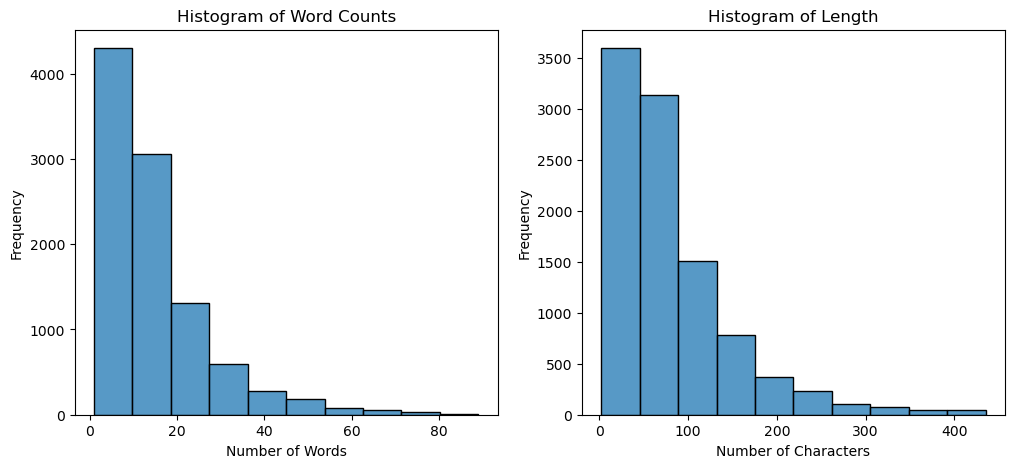

In [14]:
# Plot the distribution of word counts 
plt.figure(figsize=(12, 5)) 
plt.subplot(1, 2, 1) 
sns.histplot(df['status_word_count'], bins=10) 
plt.title('Histogram of Word Counts') 
plt.xlabel('Number of Words') 
plt.ylabel('Frequency') 

# Plot the distribution of lengths based on character
plt.subplot(1, 2, 2) 
sns.histplot(df['status_length'], bins=10) 
plt.title('Histogram of Length') 
plt.xlabel('Number of Characters') 
plt.ylabel('Frequency') 
plt.show();

---

## EDA of Personality Scores

There are two sets of personality columns in the dataset: class and score. According to the attached paper, scores have been converted to categories based on whether a score for a user fell above or below the median.

### Plot the distributions of personality scores for all five score columns:

In [16]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

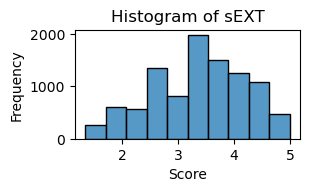

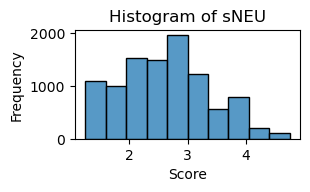

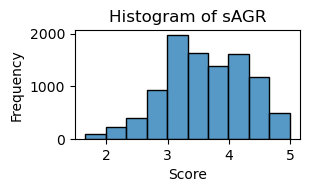

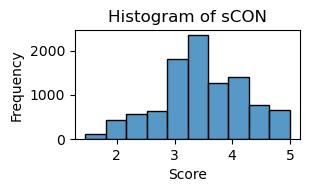

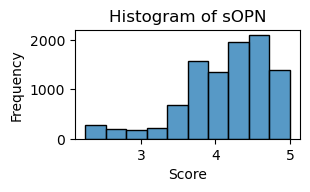

In [17]:
columns_personality = ['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN']

for i, column in enumerate(columns_personality, 1): 
    plt.subplot(3, 2, i) 
    sns.histplot(df[column], bins=10) 
    plt.title(f'Histogram of {column}') 
    plt.xlabel('Score') 
    plt.ylabel('Frequency')
    plt.show()

---

### How many unique users exist in the dataset?

This dataset has redacted original poster names, but each user is given an `#AUTHID`. How many unique users are there, and how many posts per user do we have?

In [19]:
total_unique_users = df['#AUTHID'].nunique() 
print(f'The number of unique users are: {total_unique_users}')

The number of unique users are: 250


In [20]:
df['#AUTHID'].value_counts() #no. of posts per user

#AUTHID
e6cdef6f475cce3023c5b715f8c9f110    223
6f2bebc01062eb8334dccba3e048fdb5    219
527ed53d2ba3a3bc417b8402d5b2f556    194
d7e500ad854a1b6ced39e53a525b8a6d    184
0737e4e4980f56c9fb1cb5743001c917    172
                                   ... 
22d1f7b24168528163c515b1c96a879c      1
f6cb2eff458f065858363e86515beaab      1
127d3a99f86b3ee848fd0449bec048fc      1
ac8bf16a381d07c01b11651994ecb746      1
a286b7286b1247d4a7851709e9f31e1e      1
Name: count, Length: 250, dtype: int64

## EDA on unique users

Because we have many posts per user for most users, doing EDA on the personality score columns might be misleading. If we have 200 Facebook statuses from one very high-conscientiousness user, a bar chart of how many `'cCON'` statuses are associated with `'y'` might be misleading. We'll have to be careful about labeling and titling any visualizations we make off of the dataset.

**Create a new dataframe called `unique_users` that only contains the `#AUTHID`, personality score, and personality category columns:**

If you do this correctly, it should have 250 rows and 11 columns.

(Hint: You can use the pandas [**drop_duplicates()**](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.drop_duplicates.html) method to make this easier. The only column you want to consider when deciding if a user is duplicated is the `#AUTHID` column.)

In [22]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

In [23]:
unique_users = df.drop_duplicates(subset=['#AUTHID'])[['#AUTHID', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT', 'cNEU', 'cAGR', 'cCON', 'cOPN']]

In [24]:
unique_users.shape

(250, 11)

**Plot the distribution of personality scores for `unique_users`:**

Do the distributions look different? Here, each individual user will only be represented once.

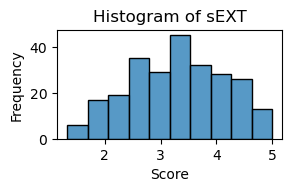

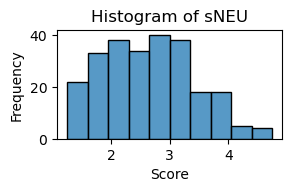

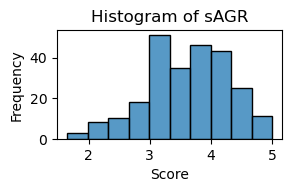

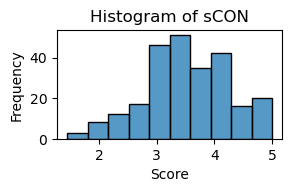

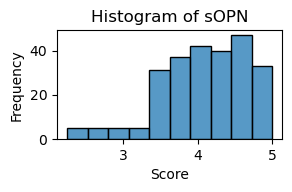

In [26]:
columns_personality = ['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN']

for i, column in enumerate(columns_personality, 1): 
    plt.subplot(3, 2, i) 
    sns.histplot(unique_users[column], bins=10) 
    plt.title(f'Histogram of {column}') 
    plt.xlabel('Score') 
    plt.ylabel('Frequency')
    plt.show()

#yes the histograms are slightly different in terms of summary statistics such as mean and medians have slightly shifted up for some (not all) personalities.

**Use the `.describe()` method on `unique_users`:**

In [28]:
unique_users.describe().round(3)

,sEXT,sNEU,sAGR,sCON,sOPN
count,250.000,250.000,250.000,250.000,250.000
mean,3.292,2.627,3.600,3.523,4.079
std,0.861,0.777,0.671,0.740,0.575
min,1.330,1.250,1.650,1.450,2.250
25%,2.662,2.000,3.150,3.000,3.750
50%,3.300,2.590,3.660,3.500,4.150
75%,4.000,3.150,4.100,4.050,4.500
max,5.000,4.750,5.000,5.000,5.000


In [29]:
df.describe().round(3)

,sEXT,sNEU,sAGR,sCON,sOPN,status_length,status_word_count
count,9916.000,9916.00,9916.000,9916.000,9916.000,9916.000,9916.000
mean,3.355,2.61,3.617,3.474,4.130,80.647,14.525
std,0.858,0.76,0.682,0.737,0.586,68.243,12.463
min,1.330,1.25,1.650,1.450,2.250,2.000,1.000
25%,2.710,2.00,3.140,3.000,3.750,34.000,6.000
50%,3.400,2.60,3.650,3.400,4.250,60.000,11.000
75%,4.000,3.05,4.150,4.000,4.550,104.000,19.000
max,5.000,4.75,5.000,5.000,5.000,435.000,89.000


### Plots vs. Tables

Consider what different information is easily conveyed by the plots of scores, versus the table with summary statistics. Explain when you might present a distribution versus when you might present a table of summary statistics.

In [31]:
## ANS: Histograms are a visual representation whereas summary statistics are more detailed numerical information.

In [32]:
# ## Histograms
# 1. Shows the shape and spread of data with overall distribution, skewness and outliers. Patterns can be identified such as right/left skew, or if it is a binomial distribution. It is easy to see where the majority of the data is located (from the frequency).

# ## Summary statistics
# 1. Gives a more precise numerical value of each characteristic of the data such as the mean, median, mode, and standard deviation. Can quantify the comparisons between the different data columns or datasets.

#### Other visualizations:

Create at least 2 additional visualizations related to the `unique_users` dataframe.

You might consider:
- Bar charts of users per category per trait
- Seaborn correlation heatmap
- Seaborn pairplot

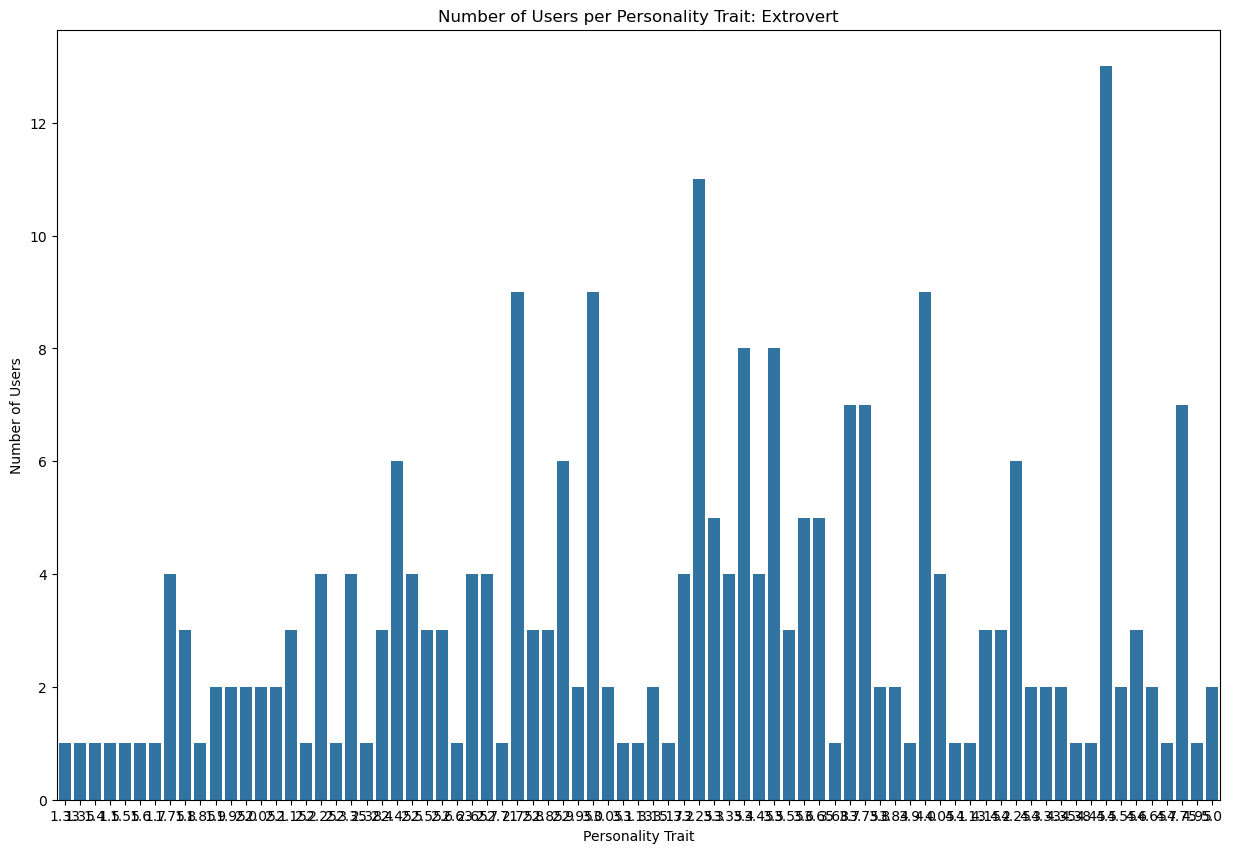

In [34]:
plt.figure(figsize=(15, 10))
sns.countplot(data=unique_users, x='sEXT')  #'sNEU', 'sAGR', 'sCON', 'sOPN'
plt.title(f'Number of Users per Personality Trait: Extrovert') 
plt.xlabel('Personality Trait') 
plt.ylabel('Number of Users')
plt.show()

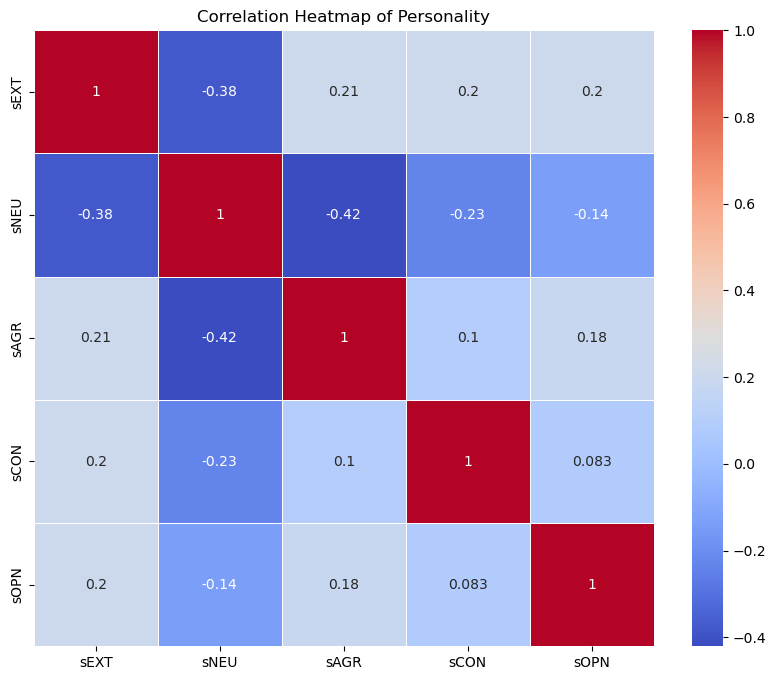

In [35]:
# Create a Seaborn correlation heatmap 
plt.figure(figsize=(10, 8)) 
sns.heatmap(unique_users.corr(numeric_only=True), annot=True, cmap='coolwarm', linewidths=0.5) 
plt.title('Correlation Heatmap of Personality') 
plt.show()

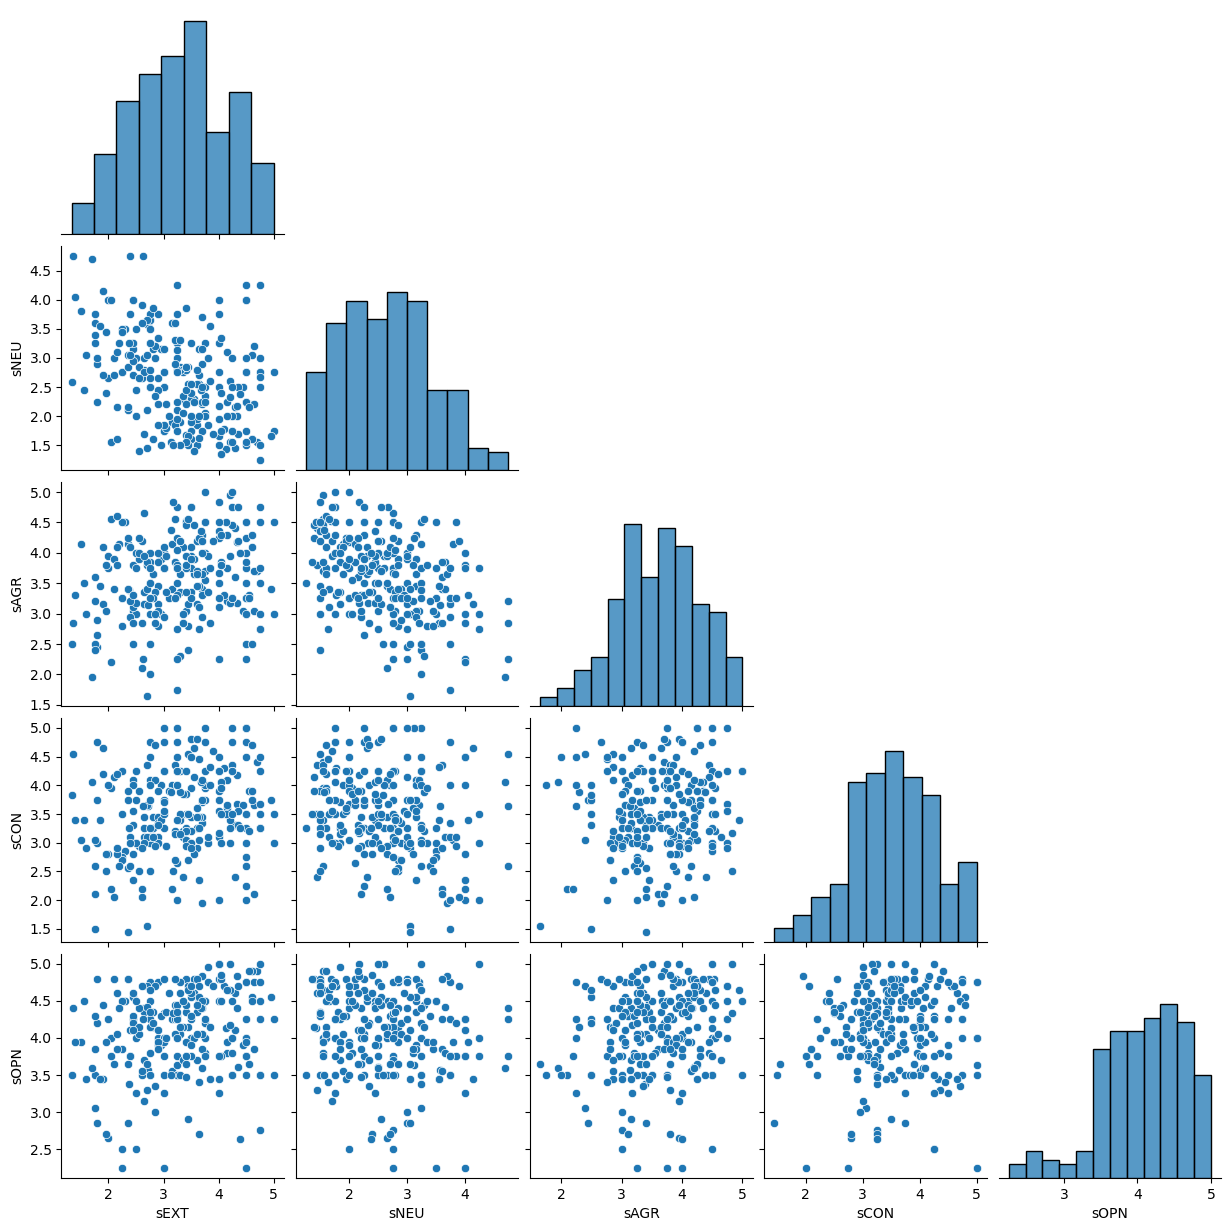

In [36]:
sns.pairplot(unique_users, corner=True)
plt.show()

---

## Exploring status length and word count based on personality

**Using `groupby()`, find the mean status length and status word count for posts by users in the high and low categories of each of the Big 5 traits.**

You'll need to use `groupby()` five separate times for this.

In [38]:
# sEXT  
sEXT_means = df.groupby('sEXT')[['status_length', 'status_word_count']].mean() 
print('Mean Status Length and Word Count for sEXT:') 
print(sEXT_means) 
# sNEU 
sNEU_means = df.groupby('sNEU')[['status_length', 'status_word_count']].mean() 
print('\nMean Status Length and Word Count for sNEU:') 
print(sNEU_means) 
# sAGR 
sAGR_means = df.groupby('sAGR')[['status_length', 'status_word_count']].mean()
print('\nMean Status Length and Word Count for sAGR:') 
print(sAGR_means) 
# sCON 
sCON_means = df.groupby('sCON')[['status_length', 'status_word_count']].mean() 
print('\nMean Status Length and Word Count for sCON:') 
print(sCON_means) 
# sOPN 
sOPN_means = df.groupby('sOPN')[['status_length', 'status_word_count']].mean() 
print('\nMean Status Length and Word Count for sOPN:') 
print(sOPN_means)

Mean Status Length and Word Count for sEXT:
      status_length  status_word_count
sEXT                                  
1.33      45.000000          10.000000
1.35      45.540541           8.527027
1.40      21.000000           4.000000
1.50      49.607143           8.696429
1.55      68.362745          12.460784
...             ...                ...
4.65      80.629630          14.925926
4.70     162.027397          30.712329
4.75      66.034014          11.666667
4.95      73.733333          13.400000
5.00      70.470320          10.981735

[77 rows x 2 columns]

Mean Status Length and Word Count for sNEU:
      status_length  status_word_count
sNEU                                  
1.25      55.500000           9.571429
1.35      55.640000           9.920000
1.40      54.784615           9.615385
1.43     106.571429          18.704082
1.45      77.690141          14.253521
...             ...                ...
4.05      21.000000           4.000000
4.15      15.000000           

**Choose one of the personality category columns (i.e. `cOPN`, `cCON`, `cEXT`, `cAGR`, or `cNEU`.) Use `sns.distplot()` to visualize the distribution of status word counts for posts by users who score both high (`y`) and low (`n`) in that personality category:**

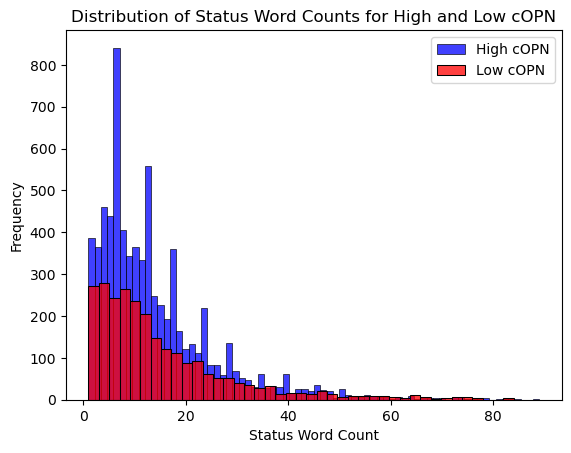

In [40]:
# Filter high and low scores in cOPN 
df_high_cOPN = df[df['cOPN'] == 'y'] 
df_low_cOPN = df[df['cOPN'] == 'n']

sns.histplot(df_high_cOPN['status_word_count'], color='blue', label='High cOPN') 
sns.histplot(df_low_cOPN['status_word_count'], color='red', label='Low cOPN') 
plt.title('Distribution of Status Word Counts for High and Low cOPN') 
plt.xlabel('Status Word Count') 
plt.ylabel('Frequency') 
plt.legend() 
plt.show()

---

## EDA on Word Counts

### Vectorize the text

In order to perform EDA on word count data, we'll need to count vectorize.

Create a dataframe that contains the count-vectorized text for each Facebook status in the dataset.

To do this, you might follow these steps:
- Instantiate a `CountVectorizer` object
- Fit the count vectorizer on the Facebook statuses
- Store the transformed data
- Convert to a dataframe and store
    - Don't forget that the transformed data will need to be 'densified'. The `toarray()` or `todense()` methods will allow this.
    - Don't forget that the `get_feature_names_out()` method on a fitted `CountVectorizer` object will bring you back the words learned from the dataset, which you can set as the `columns` argument when creating the dataframe.
    
It's up to you whether or not to keep stopwords in the dataset.

### Show the 15 most common words

In [43]:
df.head()

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
0,b7b7764cfa1c523e4e93ab2a79a946c4,likes the sound of thunder.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/19/09 03:21 PM,27,5
1,b7b7764cfa1c523e4e93ab2a79a946c4,is so sleepy it's not even funny that's she can't get to sleep.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/02/09 08:41 AM,63,13
2,b7b7764cfa1c523e4e93ab2a79a946c4,"is sore and wants the knot of muscles at the base of her neck to stop hurting. On the other hand, YAY I'M IN ILLINOIS! <3",2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/15/09 01:15 PM,121,26
3,b7b7764cfa1c523e4e93ab2a79a946c4,likes how the day sounds in this new song.,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,06/22/09 04:48 AM,42,9
4,b7b7764cfa1c523e4e93ab2a79a946c4,is home. <3,2.65,3.0,3.15,3.25,4.4,n,y,n,n,y,07/20/09 02:31 AM,11,3


In [44]:
# Create numeric label columns 
df['cEXT'] = df['cEXT'].map({'n':0, 'y':1})
df['cNEU'] = df['cNEU'].map({'n':0, 'y':1})
df['cAGR'] = df['cAGR'].map({'n':0, 'y':1})
df['cCON'] = df['cCON'].map({'n':0, 'y':1})
df['cOPN'] = df['cOPN'].map({'n':0, 'y':1})

In [45]:
df['cEXT'].value_counts(normalize=True).mul(100).round(2)

cEXT
0    57.55
1    42.45
Name: proportion, dtype: float64

In [46]:
X = df['STATUS']
y= df['cEXT']

In [47]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.25,
                                                    stratify=y,
                                                    random_state=42)

In [48]:
y_train.value_counts(normalize=True).mul(100).round(2)

cEXT
0    57.55
1    42.45
Name: proportion, dtype: float64

In [49]:
y_test.value_counts(normalize=True).mul(100).round(2)

cEXT
0    57.56
1    42.44
Name: proportion, dtype: float64

In [50]:
cvec = CountVectorizer(stop_words='english') #RERUN this cellll

In [51]:
# Fit the vectorizer on our corpus.
cvec.fit(X_train)

CountVectorizer(stop_words='english')

In [52]:
# Transform the corpus.
X_train = cvec.transform(X_train)

In [53]:
X_train

<7437x12737 sparse matrix of type '<class 'numpy.int64'>'
	with 52012 stored elements in Compressed Sparse Row format>

In [54]:
X_train.shape

(7437, 12737)

In [55]:
X_train.todense()

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [56]:
X_train_df = pd.DataFrame(X_train.todense(), columns=cvec.get_feature_names_out())
X_train_df.columns

Index(['00', '000', '000ft', '00am', '00pm', '01', '02', '03', '05', '07',
       ...
       'échangé', 'équipe', 'étais', 'était', 'étant', 'état', 'être',
       'østersund', 'últimas', 'últimos'],
      dtype='object', length=12737)

In [57]:
X_train_df['is_ext'] = y_train.values

In [58]:
X_train_df.groupby('is_ext').sum().T.sort_values(1, ascending=True).tail(20)

is_ext,0,1
tomorrow,126,90
happy,121,91
tonight,112,93
really,100,94
know,105,97
love,115,99
life,80,100
today,187,104
new,169,106
got,152,106


In [59]:
X_test = cvec.transform(X_test)

In [60]:
X_test.shape

(2479, 12737)

### Show the 15 frequency of the most common words as a bar chart

**Hint**: You can do this in one line of code. [This webpage](https://dfrieds.com/data-visualizations/bar-plot-python-pandas.html) has an example.

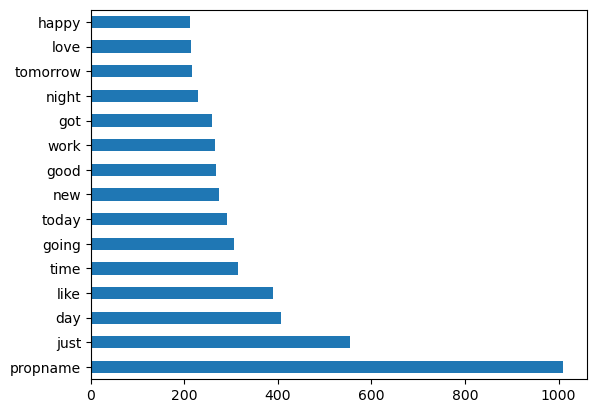

In [62]:
# Convert X_train into a DataFrame
X_train_df = pd.DataFrame(X_train.todense(), 
                          columns=cvec.get_feature_names_out())

# plot top 15 occurring words
X_train_df.sum().sort_values(ascending=False).head(15).plot(kind='barh');

### Investigating `propname`

The word `propname` shows up frequently in this dataset. Show the first 10 statuses in the dataset that contain `propname`:

In [64]:
df[df['STATUS'].str.contains('propname', case=False, na=False)].head(10)

,#AUTHID,STATUS,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,DATE,status_length,status_word_count
6,b7b7764cfa1c523e4e93ab2a79a946c4,"saw a nun zombie, and liked it. Also, *PROPNAME* + Tentacle!Man + Psychic Powers = GREAT Party.",2.65,3.00,3.15,3.25,4.40,0,1,0,0,1,06/27/09 05:41 AM,95,17
18,b7b7764cfa1c523e4e93ab2a79a946c4,"is tired. *PROPNAME*, let me go to sleep pl0x.",2.65,3.00,3.15,3.25,4.40,0,1,0,0,1,07/11/09 05:44 AM,46,9
69,b7b7764cfa1c523e4e93ab2a79a946c4,has a fair idea of how to manage the 2.5 kids cliche... She just needs a very strong gentleman named *PROPNAME* and thriteen wet napkins.,2.65,3.00,3.15,3.25,4.40,0,1,0,0,1,11/24/09 05:07 AM,137,25
101,b7b7764cfa1c523e4e93ab2a79a946c4,has a serious crush on *PROPNAME*. <3,2.65,3.00,3.15,3.25,4.40,0,1,0,0,1,01/25/10 02:57 AM,37,7
104,318bf822d4f2bd3920367560218619c0,Mondays are the new thursdays- anthony bourdain + *PROPNAME* = forgetting your financial troubles,4.50,4.00,3.00,4.50,3.75,1,1,0,1,0,06/23/09 05:41 AM,98,14
118,318bf822d4f2bd3920367560218619c0,is *PROPNAME*'s bestbian,4.50,4.00,3.00,4.50,3.75,1,1,0,1,0,08/23/09 06:03 AM,24,3
139,318bf822d4f2bd3920367560218619c0,is in love with *PROPNAME*.,4.50,4.00,3.00,4.50,3.75,1,1,0,1,0,10/04/09 03:09 AM,27,5
158,318bf822d4f2bd3920367560218619c0,is in love. With *PROPNAME*.,4.50,4.00,3.00,4.50,3.75,1,1,0,1,0,12/11/09 05:35 AM,28,5
170,318bf822d4f2bd3920367560218619c0,Ten Movies to Watch Right Now (and some you can Instant Netflix) 1. La Vie En Rose 2. Shrink (if you love LA) 3. Paris Je'taime (if you love Paris) 3. Clay Pidgeons (*PROPNAME* is priceless) 4. Quills 5. Away We Go 6. Sunshine Cleaning 7. A League of Their Own 8. Smart People (I Heart *PROPNAME*'s Page and SJP) 9. Frost//Nixon 10. Doubt,4.50,4.00,3.00,4.50,3.75,1,1,0,1,0,10/11/09 01:39 AM,338,64
202,ecbddbfe00e0f83cfdb802a7186061c7,"ATTENTION EVERYONE!!! Vote for the short ""AFTER HOURS"" to support *PROPNAME* - our local Michigan talent and a wonderful person. Repost please!!! http:////www.thirteen.org//sites//reel13//category//vote//",4.30,2.15,3.60,3.30,4.10,1,0,1,0,1,11/24/09 07:11 AM,204,23


**Provide a short explanation of what you believe `propname` to be:**

In [66]:
#as mentioned above, `PROPNAME` has been used to redact personal names so the user' actual names will not show up.

## Most common words based on personality category

In order to do more targeted EDA, we'll need to be able to reference not only the dataframe of vectorized statuses, but also the personality scores from the original dataframe.

**Create a new dataframe called `text_and_scores` that concatenates the count-vectorized statuses side-by-side with the original personality category columns:**

In [68]:
df.columns

Index(['#AUTHID', 'STATUS', 'sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN', 'DATE', 'status_length',
       'status_word_count'],
      dtype='object')

In [69]:
df.shape

(9916, 15)

In [70]:
X_train_df.head(3)

,00,000,000ft,00am,00pm,01,02,03,05,07,...,échangé,équipe,étais,était,étant,état,être,østersund,últimas,últimos
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
X_train_df.shape

(7437, 12737)

In [72]:
text_and_scores = pd.concat([df[['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cAGR', 'cCON', 'cOPN']], X_train_df], axis=1)

In [73]:
text_and_scores.columns

Index(['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT', 'cNEU', 'cAGR', 'cCON',
       'cOPN',
       ...
       'échangé', 'équipe', 'étais', 'était', 'étant', 'état', 'être',
       'østersund', 'últimas', 'últimos'],
      dtype='object', length=12747)

**Show the 25 most common words for statuses from high-cAGR users:**

In [137]:
text_and_scores[text_and_scores['cAGR'] == 1]

,sEXT,sNEU,sAGR,sCON,sOPN,cEXT,cNEU,cAGR,cCON,cOPN,...,échangé,équipe,étais,était,étant,état,être,østersund,últimas,últimos
171,4.30,2.15,3.6,3.30,4.1,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
172,4.30,2.15,3.6,3.30,4.1,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,4.30,2.15,3.6,3.30,4.1,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
174,4.30,2.15,3.6,3.30,4.1,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175,4.30,2.15,3.6,3.30,4.1,1,0,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9909,3.70,2.50,4.2,4.10,3.6,1,0,1,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9910,2.15,2.15,4.1,2.90,4.6,0,0,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9911,2.15,2.15,4.1,2.90,4.6,0,0,1,0,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9912,4.05,3.35,3.8,3.95,4.5,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [145]:
# drop other unneeded personalities columns
cAGR_df = text_and_scores.drop(columns=['sEXT', 'sNEU', 'sAGR', 'sCON', 'sOPN', 'cEXT',
       'cNEU', 'cCON', 'cOPN'])

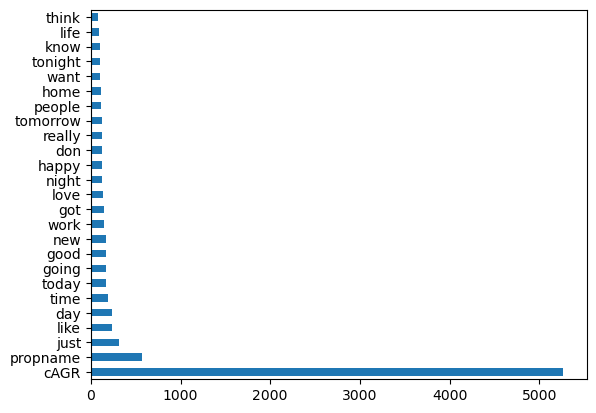

In [151]:
# plot top 25 occurring words for high-cAGR =1
cAGR_df[cAGR_df['cAGR'] == 1].sum().sort_values(ascending=False).head(25).plot(kind='barh');

**Show the 25 most common words for statuses from low-cAGR users:**

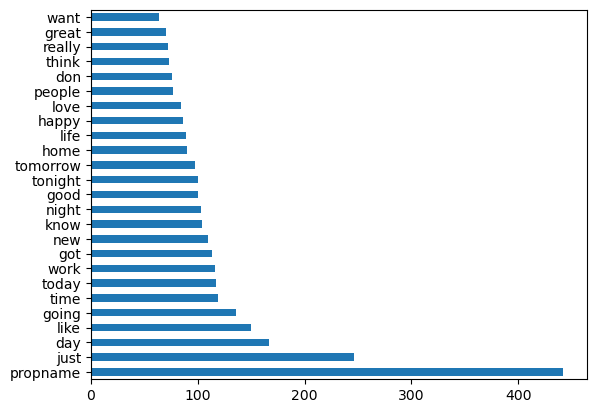

In [149]:
# plot top 25 occurring words for low-cAGR = 0
cAGR_df[cAGR_df['cAGR'] == 0].sum().sort_values(ascending=False).head(25).plot(kind='barh');

### Most common bigrams:

Find the 10 most common [**bigrams**](https://en.wikipedia.org/wiki/Bigram) in the dataset.

In [183]:
import nltk

In [175]:
#bigrams (1, 2) top ten
bigram_counts = (pd.Series(nltk.ngrams(X_train_df, 2)).value_counts())[:10]

In [177]:
bigram_counts

(00, 000)                 1
(polyps, polystrate)      1
(pomegranate, pompous)    1
(pompous, pond)           1
(pond, pondering)         1
(pondering, poner)        1
(poner, pong)             1
(pong, pongal)            1
(pongal, pontipines)      1
(pontipines, pony)        1
Name: count, dtype: int64

### Most common trigrams:

Find the 10 most common [**trigrams**](https://en.wikipedia.org/wiki/Trigram) in the dataset.

In [179]:
#trigrams(1,2,3)
trigram_counts = (pd.Series(nltk.ngrams(X_train_df, 3)).value_counts())[:10]

In [181]:
trigram_counts

(00, 000, 000ft)                      1
(polyglot, polyps, polystrate)        1
(polystrate, pomegranate, pompous)    1
(pomegranate, pompous, pond)          1
(pompous, pond, pondering)            1
(pond, pondering, poner)              1
(pondering, poner, pong)              1
(poner, pong, pongal)                 1
(pong, pongal, pontipines)            1
(pongal, pontipines, pony)            1
Name: count, dtype: int64

---

## Choose your own adventure

By now you've looked at a lot of visualizations and frequency counts.

Come up with 2-3 questions about the data, and try to answer them using descriptive statistics (like counts, averages, etc.) or visualizations.

Some questions you might explore:
- Have numbers been redacted, or are phone numbers, house numbers, or zip codes anywhere in the dataset?
- `PROPNAME` has been used to redact personal names. Given that this data was scraped between 2009 and 2011, investigate if any public figures or famous people show up in the dataset, or their names have been redacted as well.
- Is count of uppercase letters vs. lowercase letters per status related to any personality category or personality score?
- Is _average_ word count per status related to any personality category or personality metric?
- Is punctuation use related to personality?

Or, of course, come up with your own questions to investigate!

The focus here is on "explore" -- you might not find anything of particular interest, but don't let that discourage you.

In [199]:
#phone numbers, house no., zip codes redacted? #ANSW: No, the phone numbers are still intact, e.g. 714 612 0723, and Call 773-962-7899!!!! in output below
import re

phone_pattern = re.compile(r'\b\d{3}[-.\s]?\d{3}[-.\s]?\d{4}\b') 
house_pattern = re.compile(r'\b\d{1,5}\s[A-Za-z]+\s[A-Za-z]+\b') 
zip_pattern = re.compile(r'\b\d{5}(?:-\d{4})?\b')

In [201]:
def search_patterns(df, patterns): 
    matches = [] 
    for pattern in patterns: 
        for col in df.columns: 
            matched = df[col].apply(lambda x: bool(pattern.search(str(x)))) 
            if matched.any(): 
                matches.extend(df.loc[matched, col].tolist()) 
    return matches 

patterns = [phone_pattern, house_pattern, zip_pattern] 
# Find matches 
matches = search_patterns(df, patterns) 
print('Matches:', matches)

Matches: ['going to the AFI rise against show tonight.  I have 2 extra tickets call me if you wanna buy them 714 612 0723.', "I've got cheap *PROPNAME* tickets!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! Call 773-962-7899!!!!", 'AMERICAN AIRLINES is taking doctors and nurses to Haiti for free. Please call 212-697-9767. Spread the word. if you are looking for ways to be of any help... UPS IS SHIPPING TO HAITI FOR FREE TOMORROW!! IT HAS TO BE UNDER 50 lbs!! If you have ANYTHING to give, round up your stuff and... send it out!! PLEASE repost this... to spread the word PLEASE repost!!!!', 'relaxing at Chapel Ridge Pool...call me if you would like to join. 252-646-3927!', "URGENT!!  Does anyone want to see SONIC YOUTH with DINOSAUR JR. TONIGHT at Terminal 5 in Manhattan (show starts 8 PM)??  Sean is sick and can't go so I have a FREE TICKET to the show, which is SOLD OUT otherwise.  If you're interested, drop me a text!! 631-714-9319.", 'buy my car! http:////hartford.craigslist.org//cto//1471852203.h

In [197]:
#PROPNAME : investigate if any public figures appear e.g. "Donald Trump" ANSW: no, their names have been redacted
df['STATUS'].str.contains('donald trump', case=False, na=False).unique()

array([False])

---

## Exploratory vs. Explanatory Data Analysis 

> **Exploratory analysis** is what you do to get familiar with the data. You may start out with a hypothesis or question, or you may just really be delving into the data to determine what might be interesting about it. Exploratory analysis is the process of turning over 100 rocks to find perhaps 1 or 2 precious gemstones.
>
> **Explanatory analysis** is what happens when you have something specific you want to show an audience - probably about those 1 or 2 precious gemstones. In my blogging and writing, I tend to focus mostly on this latter piece, explanatory analysis, when you've already gone through the exploratory analysis and from this have determined something specific you want to communicate to a given audience: in other words, when you want to tell a story with data.

- Cole Nussbaumer Knaflic, [**exploratory vs. explanatory analysis**](http://www.storytellingwithdata.com/blog/2014/04/exploratory-vs-explanatory-analysis)

### Choose one visual to explain:

Now that you've performed an exploratory data analysis, choose a visual (or 1-3 related visuals) to frame as **_explanatory_**. This can be a visual you created above, or you can create a new visual. For this visual, make sure the visuals are formatted clearly, and provide a one to two paragraph explanation/interpretation of the visual.

In [ ]:
#Explanatory

# For instance, in the cOPN histplot "Distribution of Status Word Counts for High and Low cOPN" created for the above questions, 
#the users with more frequent posts (despite less words) scored higher for the personality 'Openess' than users with fewer frequent posts.